In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import time
torch.manual_seed(42)
np.random.seed(42)

# First Feature Map

In [2]:

# Configuration
n_qubits = 2
input_dim = 2
res = 30  # resolution of x1, x2 grid
X_vals = np.linspace(0, 2 * np.pi, res)
X1, X2 = np.meshgrid(X_vals, X_vals)
inputs = np.stack([X1.ravel(), X2.ravel()], axis=1)


In [3]:

# Encoding
def encoding_layer(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RY(x[0]*x[1], wires=0)
    qml.RY(x[1]*x[0], wires=1)
    
# Variational block
def variational_block(weights):
    for i in range(n_qubits):
        qml.RZ(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RZ(weights[i, 2], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 0])

# Create circuit
def create_qnode(depth, weights, dev,num_reupload):
    @qml.qnode(dev)
    def circuit(x):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_layer(x)
                count += 1
            variational_block(weights[d])
        return qml.expval(qml.PauliZ(0))
    return circuit


In [4]:

# Label from circuit
def generate_labels(circuit, X):
    return np.array([1 if circuit(x) > 0 else 0 for x in X])


In [5]:

# Quantum classifier as TorchLayer
def get_torch_model(depth, dev,num_reupload):
    weight_shapes = {"weights": (depth, n_qubits, 3)}

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_layer(inputs)
                count += 1
            for i in range(n_qubits):
                qml.RZ(weights[d, i, 0], wires=i)
                qml.RY(weights[d, i, 1], wires=i)
                qml.RZ(weights[d, i, 2], wires=i)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 0])
        return qml.expval(qml.PauliZ(0))

    return qml.qnn.TorchLayer(circuit, weight_shapes)


In [6]:

# Training loop
def train_model(model, X_train, y_train, epochs=500, lr=0.01):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    for _ in range(epochs):
        opt.zero_grad()
        outputs = torch.stack([model(x) for x in X_train])
        loss = loss_fn(outputs, y_train.squeeze())
        loss.backward()
        opt.step()
    return model


In [7]:
def plot_generator_A(generator_labels, title, X=None, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = generator_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, cmap='RdBu', alpha=0.4)
    plt.contour(X1, X2, Z, levels=2, colors='black', linewidths=0.5)

    # Optional: overlay generated class markers on the full grid
    X_flat = X1.ravel(), X2.ravel()
    labels_flat = generator_labels.ravel()
    for cls, marker in zip([0, 1], ['o', 's']):
        idx = labels_flat == cls
        plt.scatter(X_flat[0][idx], X_flat[1][idx], marker=marker, color='black', s=5, alpha=0.3, label=f'Class {cls}')

    # Optional: training points overlay
    if X is not None and train_idx is not None:
        X_train = X[train_idx]
        y_train = generator_labels[train_idx]
        for i, pt in enumerate(X_train):
            marker = 'o' if y_train[i] == 0 else 's'
            plt.scatter(pt[0], pt[1], marker=marker, color='yellow', edgecolor='black', s=40, label="Train point" if i == 0 else None)

    plt.title(title)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:

# Plot contours
def plot_results(generator_labels, predicted_labels, title, X, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = predicted_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, alpha=0.3, cmap='RdBu')
    plt.contour(X1, X2, generator_labels.reshape(res, res), levels=2, colors='black', linewidths=0.5)

    # Plot training points
    if train_idx is not None:
        X_train_pts = X[train_idx]
        y_true = generator_labels[train_idx]
        y_pred = predicted_labels[train_idx]

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)
    if train_idx is None:
        X_train_pts = X
        y_true = generator_labels
        y_pred = predicted_labels

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.tight_layout()
    plt.show()



In [9]:

# Main experiment
depths = [1, 2, 3, 4] # depths of reupload
train_idx = np.random.choice(len(inputs), size=300, replace=False)
X_train = torch.tensor(inputs[train_idx], dtype=torch.float32)
test_idx = np.setdiff1d(np.arange(len(inputs)), train_idx)
X_test = torch.tensor(inputs[test_idx], dtype=torch.float32)

results = []


  0%|          | 0/4 [00:00<?, ?it/s]

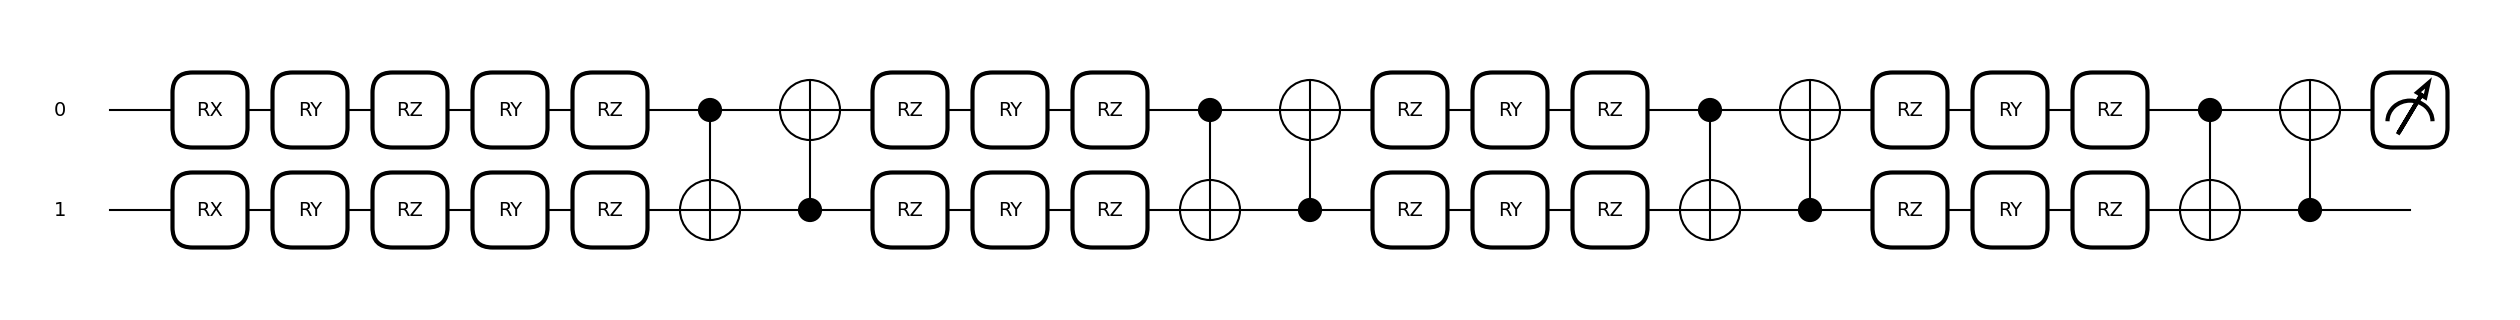

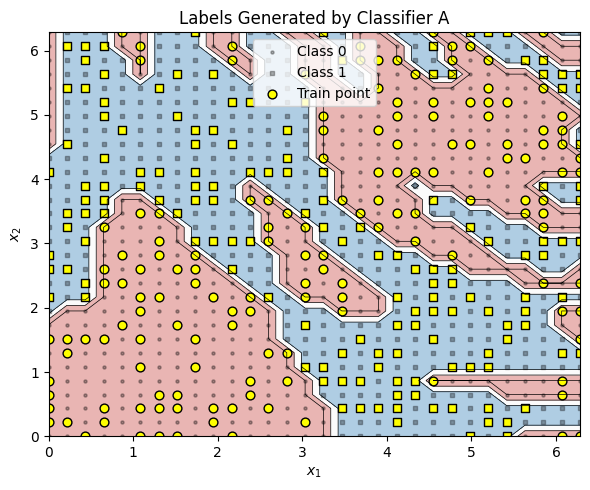

Training B(reupload=1) on data from A(reupload=1)
Total Accuracy: 0.9144444444444444
Train Accuracy: 0.92
Test Accuracy: 0.9116666666666666
Time taken: 1561.3312685489655


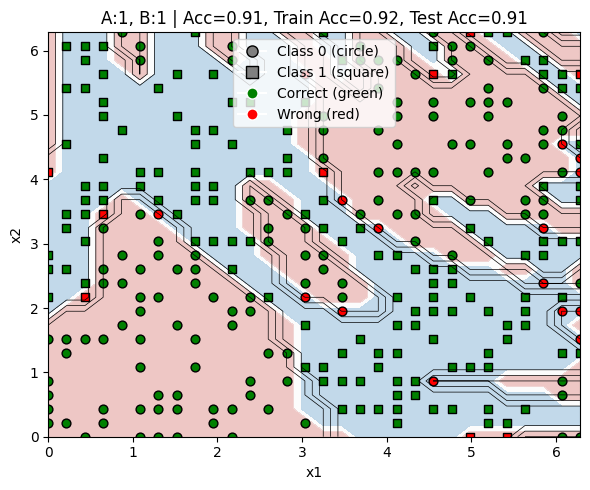

Training B(reupload=2) on data from A(reupload=1)
Total Accuracy: 0.8733333333333333
Train Accuracy: 0.88
Test Accuracy: 0.87
Time taken: 1199.753024339676


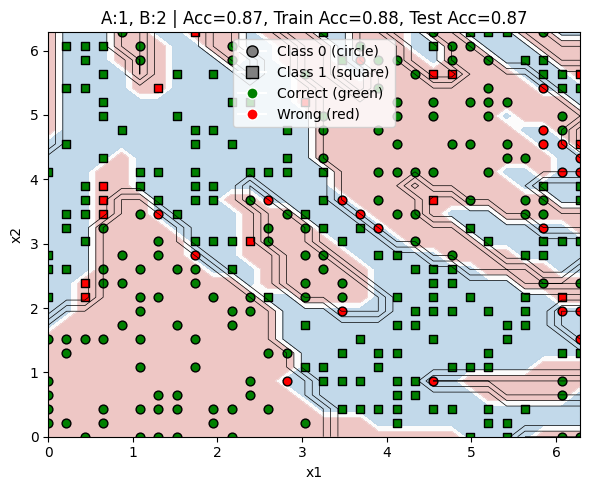

Training B(reupload=3) on data from A(reupload=1)
Total Accuracy: 0.7666666666666667
Train Accuracy: 0.7766666666666666
Test Accuracy: 0.7616666666666667
Time taken: 1252.8437991142273


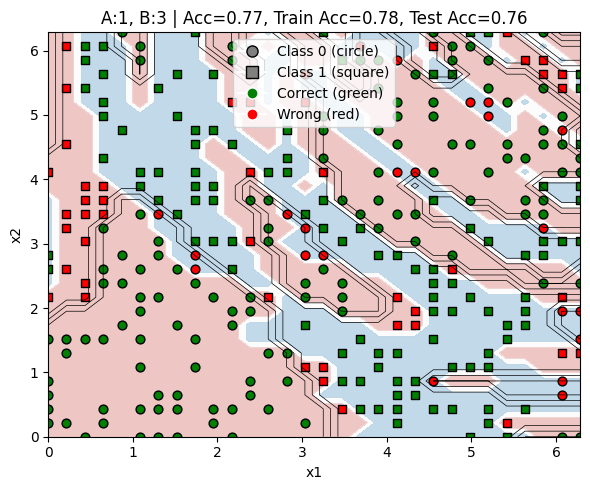

Training B(reupload=4) on data from A(reupload=1)
Total Accuracy: 0.7588888888888888
Train Accuracy: 0.8033333333333333
Test Accuracy: 0.7366666666666667
Time taken: 1326.2120130062103


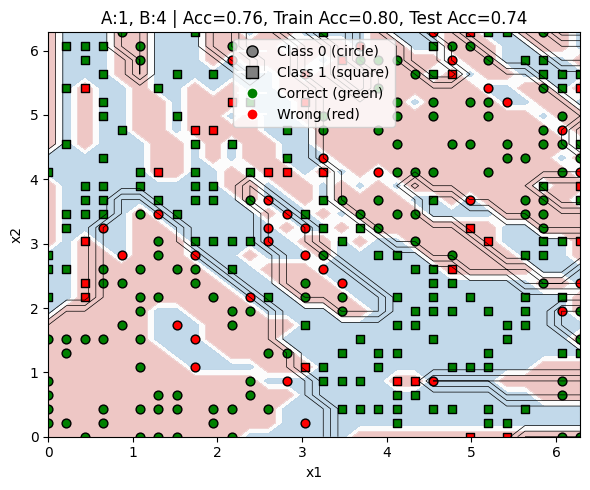

 25%|██▌       | 1/4 [1:29:07<4:27:23, 5347.86s/it]

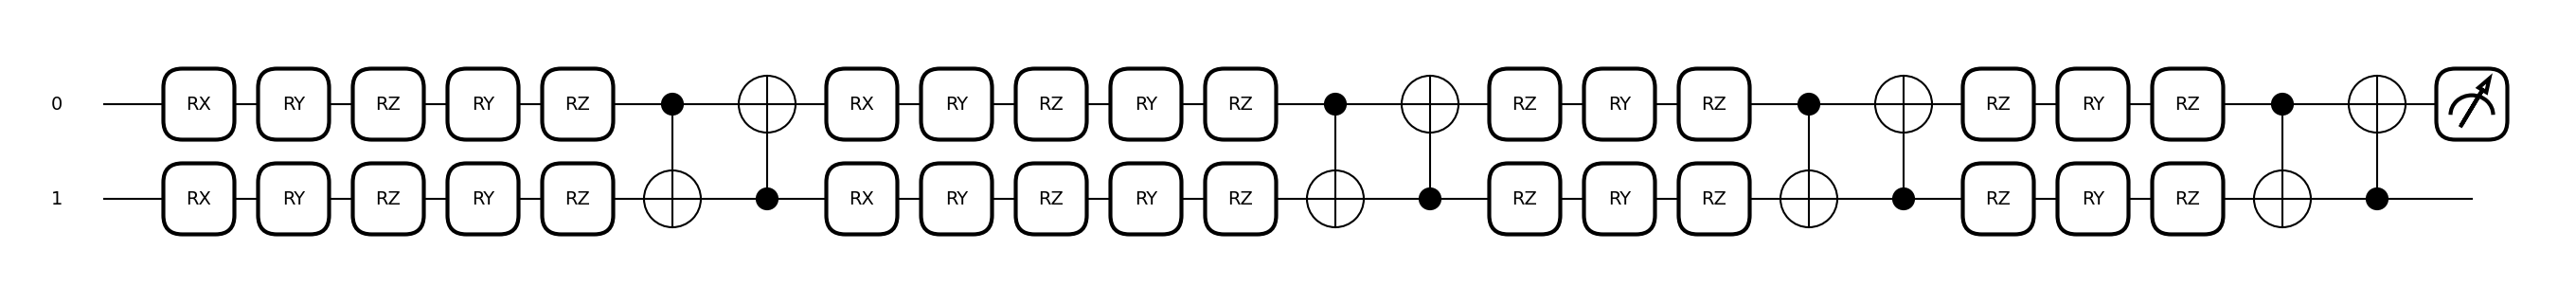

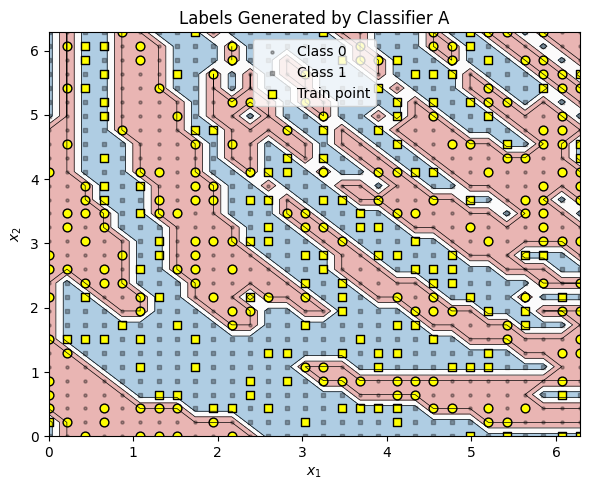

Training B(reupload=1) on data from A(reupload=2)
Total Accuracy: 0.5788888888888889
Train Accuracy: 0.6566666666666666
Test Accuracy: 0.54
Time taken: 1052.657740354538


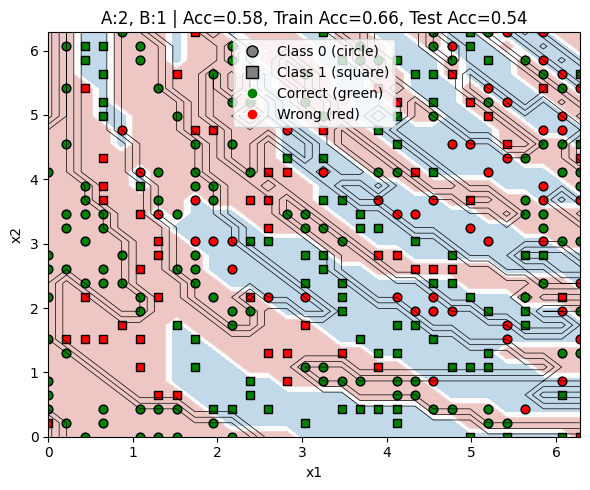

Training B(reupload=2) on data from A(reupload=2)
Total Accuracy: 0.8977777777777778
Train Accuracy: 0.9133333333333333
Test Accuracy: 0.89
Time taken: 1146.580028295517


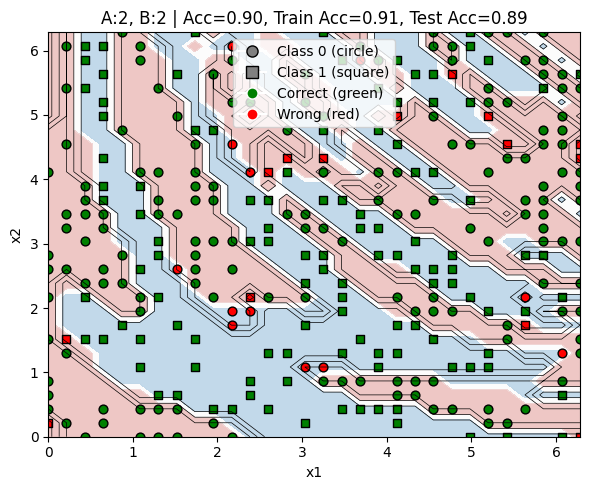

Training B(reupload=3) on data from A(reupload=2)
Total Accuracy: 0.7644444444444445
Train Accuracy: 0.8066666666666666
Test Accuracy: 0.7433333333333333
Time taken: 1239.3422214984894


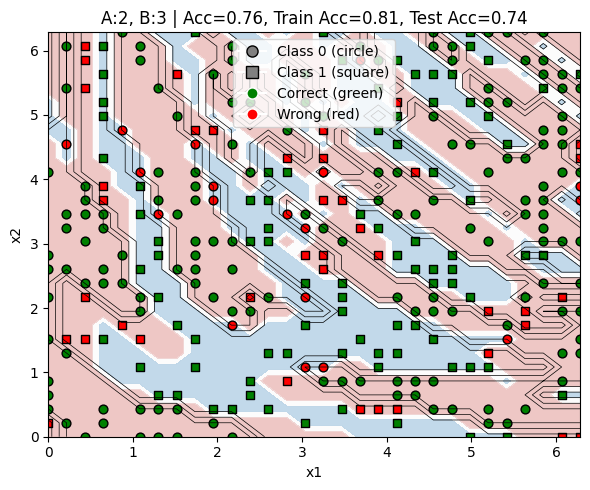

Training B(reupload=4) on data from A(reupload=2)
Total Accuracy: 0.6933333333333334
Train Accuracy: 0.7666666666666667
Test Accuracy: 0.6566666666666666
Time taken: 1325.4025480747223


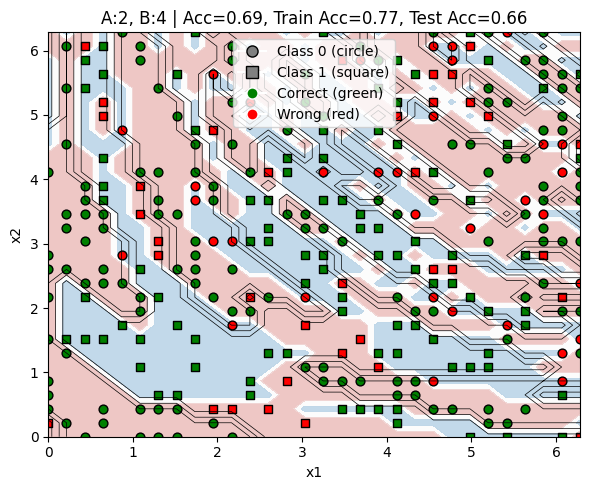

 50%|█████     | 2/4 [2:48:39<2:46:58, 5009.02s/it]

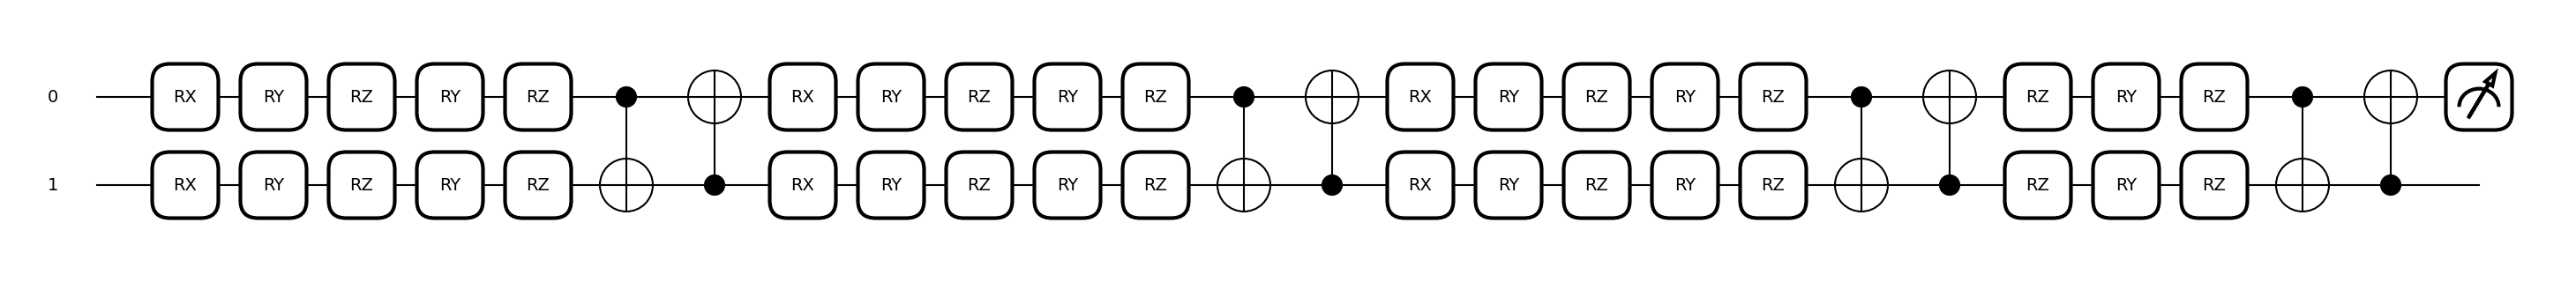

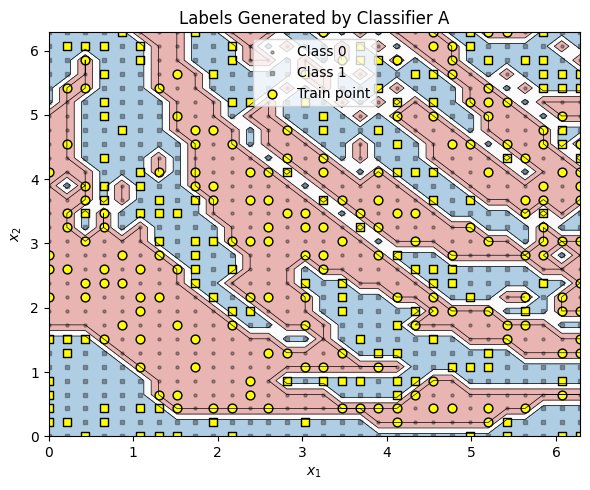

Training B(reupload=1) on data from A(reupload=3)
Total Accuracy: 0.6011111111111112
Train Accuracy: 0.6133333333333333
Test Accuracy: 0.595
Time taken: 1048.553674697876


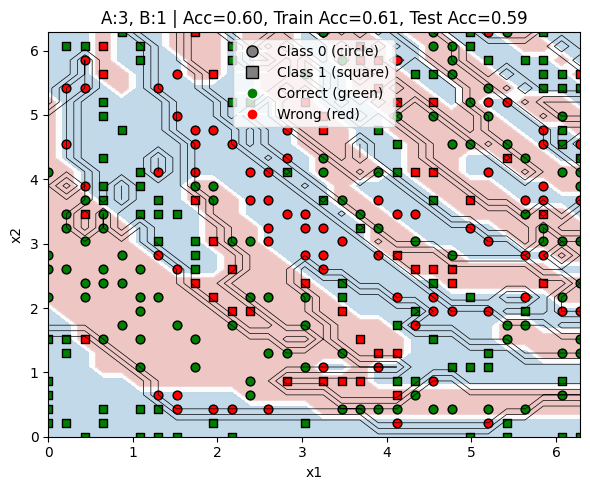

Training B(reupload=2) on data from A(reupload=3)
Total Accuracy: 0.6822222222222222
Train Accuracy: 0.7333333333333333
Test Accuracy: 0.6566666666666666
Time taken: 1145.5411643981934


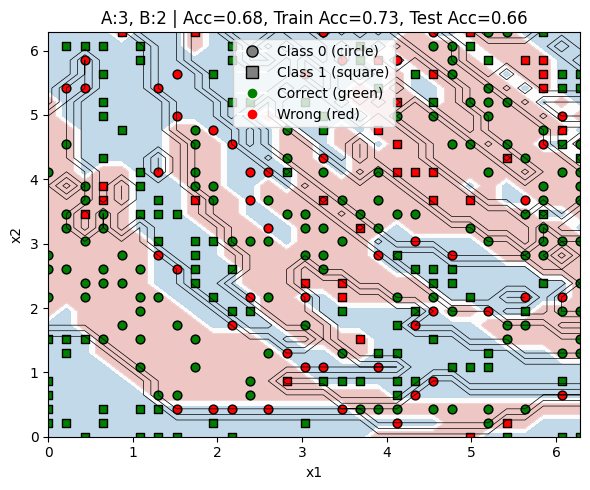

Training B(reupload=3) on data from A(reupload=3)
Total Accuracy: 0.7988888888888889
Train Accuracy: 0.8233333333333334
Test Accuracy: 0.7866666666666666
Time taken: 1236.9872462749481


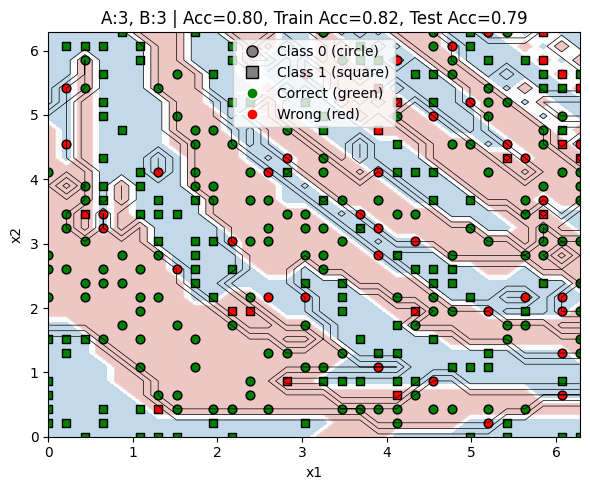

Training B(reupload=4) on data from A(reupload=3)
Total Accuracy: 0.67
Train Accuracy: 0.73
Test Accuracy: 0.64
Time taken: 1327.0806093215942


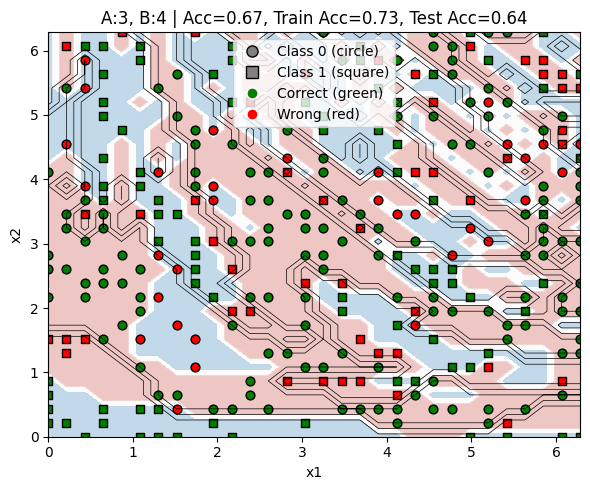

 75%|███████▌  | 3/4 [4:08:06<1:21:38, 4898.33s/it]

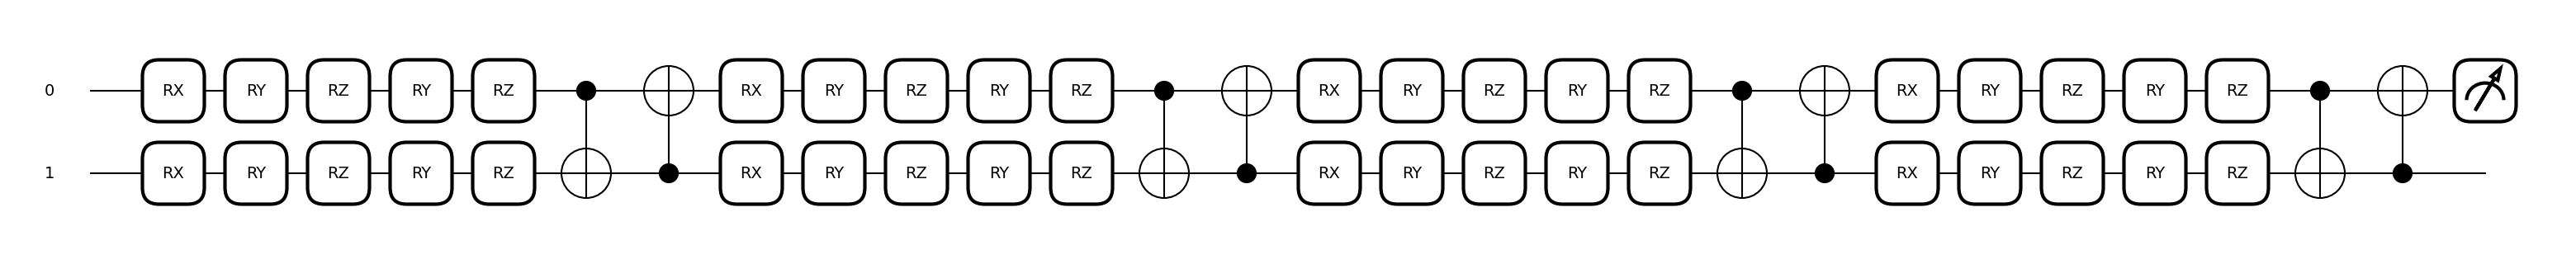

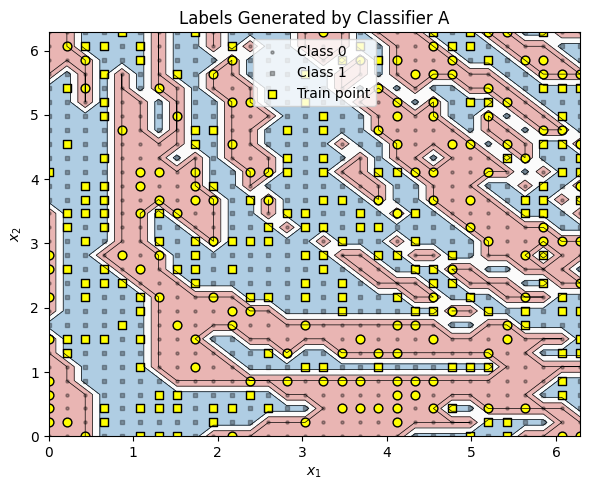

Training B(reupload=1) on data from A(reupload=4)
Total Accuracy: 0.5788888888888889
Train Accuracy: 0.6
Test Accuracy: 0.5683333333333334
Time taken: 1052.9685134887695


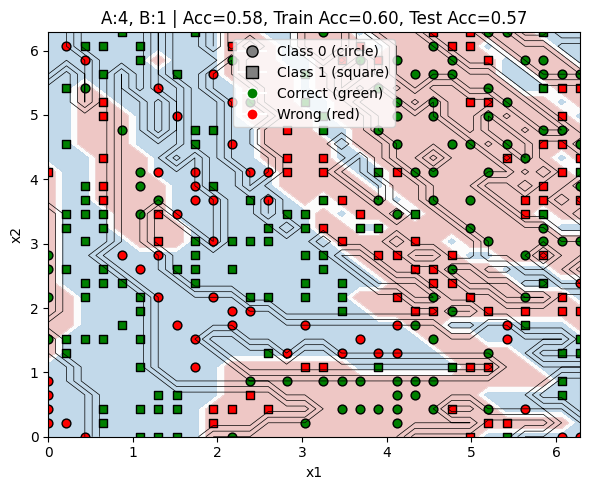

Training B(reupload=2) on data from A(reupload=4)
Total Accuracy: 0.6222222222222222
Train Accuracy: 0.6866666666666666
Test Accuracy: 0.59
Time taken: 1146.2795510292053


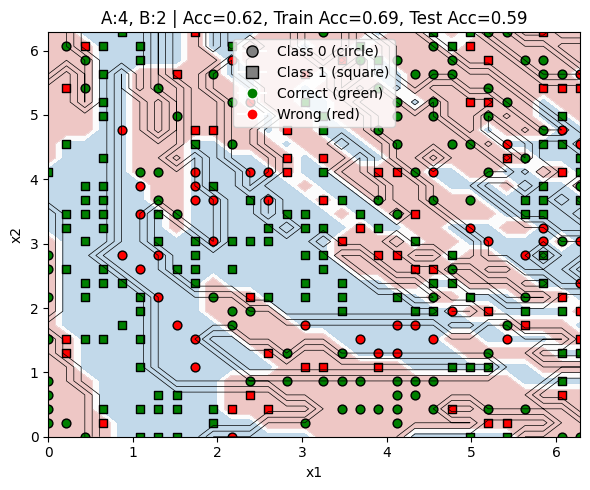

Training B(reupload=3) on data from A(reupload=4)
Total Accuracy: 0.6377777777777778
Train Accuracy: 0.7166666666666667
Test Accuracy: 0.5983333333333334
Time taken: 1235.574142217636


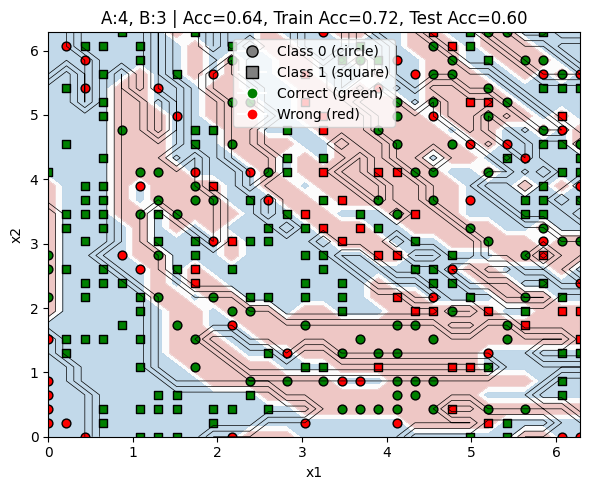

Training B(reupload=4) on data from A(reupload=4)
Total Accuracy: 0.6633333333333333
Train Accuracy: 0.7333333333333333
Test Accuracy: 0.6283333333333333
Time taken: 1326.599244594574


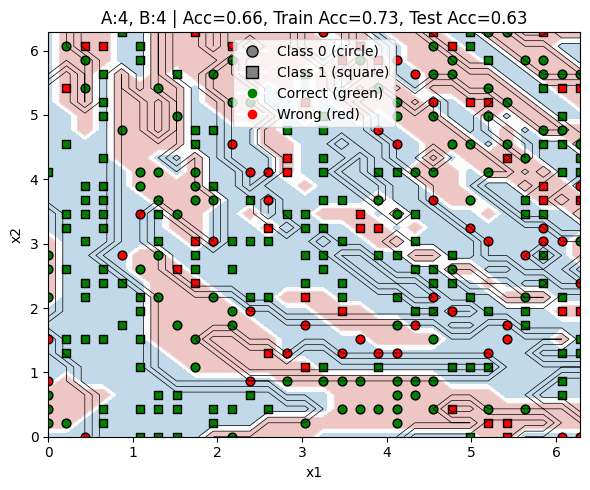

100%|██████████| 4/4 [5:27:36<00:00, 4914.08s/it]  


In [10]:

for depth_A in tqdm(depths):
    # Generate labels using fixed A
    devA = qml.device("default.qubit", wires=n_qubits)
    weights_A = np.random.uniform(0, 2*np.pi, size=(4, n_qubits, 3))
    circuit_A = create_qnode(4, weights_A, devA, depth_A)
    labels_A = generate_labels(circuit_A, inputs)
    y_train = torch.tensor(labels_A[train_idx], dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(labels_A[test_idx], dtype=torch.float32).unsqueeze(1)
    qml.drawer.draw_mpl(circuit_A)([0, 1]);
    
    plot_generator_A(labels_A, "Labels Generated by Classifier A", X=inputs, train_idx=train_idx)
    for depth_B in tqdm(depths):
        print(f"Training B(reupload={depth_B}) on data from A(reupload={depth_A})")
        devB = qml.device("default.qubit", wires=n_qubits)
        model_B = get_torch_model(4, devB, num_reupload=depth_B)
        start_time = time.time()
        trained_model = train_model(model_B, X_train, y_train)

        # Evaluate model
        with torch.no_grad():
            preds = torch.stack([trained_model(x) for x in torch.tensor(inputs, dtype=torch.float32)]).numpy().flatten()
            pred_labels = (preds > 0).astype(int)
            
        train_preds = pred_labels[train_idx]
        test_preds = pred_labels[test_idx]

        acc = accuracy_score(labels_A, pred_labels)
        
        train_acc = accuracy_score(labels_A[train_idx], train_preds)
        test_acc = accuracy_score(labels_A[test_idx], test_preds)

        # Plot
        title = f"A:{depth_A}, B:{depth_B} | Acc={acc:.2f}, Train Acc={train_acc:.2f}, Test Acc={test_acc:.2f}"
        print("Total Accuracy:", acc)
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        print("Time taken:", time.time() - start_time)
        plot_results(labels_A, pred_labels, title, inputs, train_idx)
        
        results.append((depth_A, depth_B, acc, train_acc, test_acc))




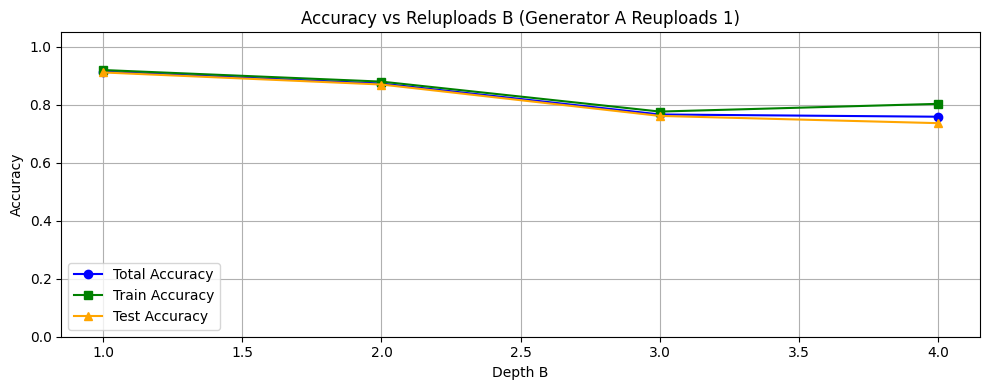

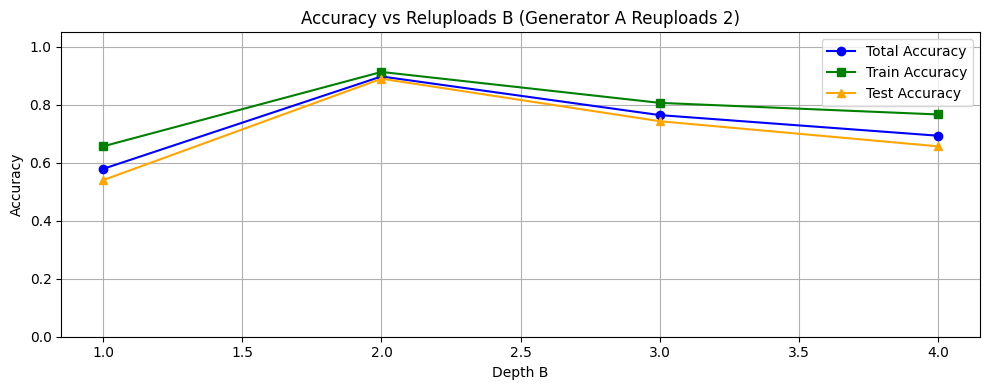

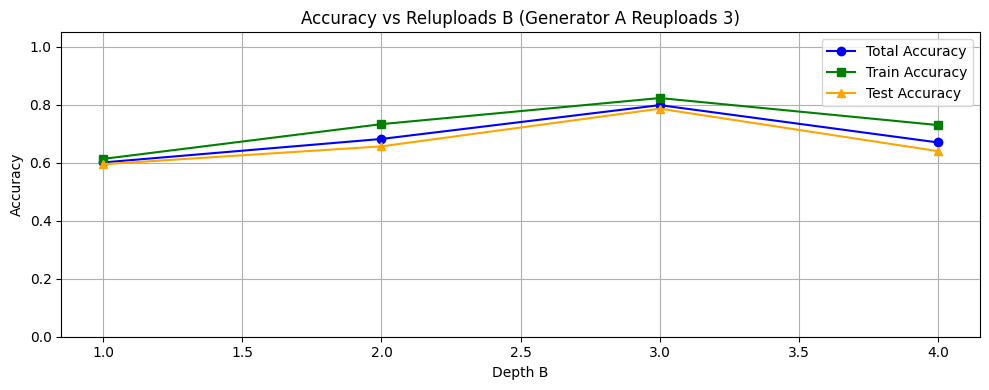

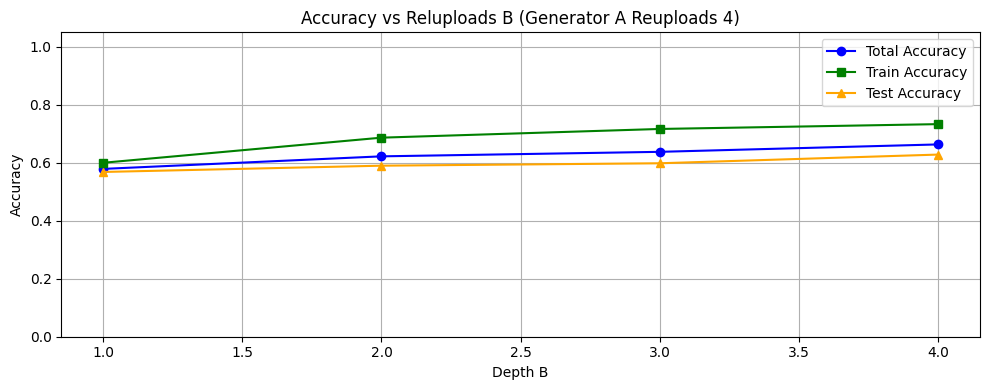

In [11]:

# Updated DataFrame with new columns
df_results = pd.DataFrame(results, columns=["depth_A", "depth_B", "total_acc", "train_acc", "test_acc"])

# Plot for each depth_A
for depth_A in df_results["depth_A"].unique():
    subset = df_results[df_results["depth_A"] == depth_A]

    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.plot(subset["depth_B"], subset["total_acc"], marker='o', label="Total Accuracy", color='blue')
    plt.plot(subset["depth_B"], subset["train_acc"], marker='s', label="Train Accuracy", color='green')
    plt.plot(subset["depth_B"], subset["test_acc"], marker='^', label="Test Accuracy", color='orange')

    plt.title(f"Accuracy vs Reluploads B (Generator A Reuploads {depth_A})")
    plt.xlabel("Depth B")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [12]:
print("done")

done
